## The Functions of the Discrete Voter Model

This notebook implements the following $6$ subroutines for the **discrete voter model**:
1. `make_grid`: create a probabilistic grid: an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$
2. `shift_weight`: shift weight in a grid reversibly
3. `expec_votes`: given a grid, a candidate, and a district description, output the expectation of votes that candidate received
4. `prob_votes`: given a grid, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome
5. `mcmc`: run a Markov Chain Monte Carlo method on a state space of grids
6. `hill_climb`: optimize the expectation or probability with gradient descent

`generate_random_election` generates a random election when given candidate and demographic information.

### `make_grid`
Create a probabilistic grid: an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$.

In [466]:
import numpy as np
from operator import mul
import functools
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import chain, permutations
from typing import Dict, List, Tuple
from tqdm import trange, tqdm_notebook
from scipy.stats import binom

sns.set(style='whitegrid')
%matplotlib inline

In [2]:
def make_grid(num_groups, matrix_size, random=True):
    """
    Create a probabilistic grid.
    
    num_groups (int): the number of groups to be represented 
    matrix_size (int): the dimensions of the matrix
    random (bool): whether the grid should be initialized uniformly
    or randomly
    
    return: a probabilistic grid
    """
    shape = tuple([matrix_size] * num_groups)
    if random:
        matrix = np.random.rand(*shape)
    else:
        matrix = np.ones(shape)
    return matrix / matrix.sum()

In [5]:
test_grid = make_grid(3, 10)

In [6]:
test_grid

array([[[3.65630210e-04, 1.50397007e-03, 1.40795378e-03, 1.13903679e-03,
         8.97903207e-04, 1.35994804e-03, 1.78409607e-03, 1.18962386e-03,
         9.68918284e-04, 1.71770131e-03],
        [1.11153907e-03, 1.33542502e-03, 1.87335113e-03, 1.41409734e-03,
         1.59721440e-04, 2.04367796e-03, 4.32391775e-04, 1.48133156e-04,
         1.95814796e-03, 1.45477867e-03],
        [1.39437148e-03, 6.66317260e-05, 7.80736924e-04, 9.74144109e-04,
         1.20502544e-03, 9.46372136e-04, 5.94548848e-04, 5.77226969e-04,
         1.15854251e-03, 1.83698813e-03],
        [5.03586313e-05, 1.14203448e-03, 1.95611561e-03, 9.53470321e-04,
         1.72613363e-03, 9.85422987e-04, 1.47796187e-03, 1.57367726e-03,
         1.85148708e-03, 7.50990388e-04],
        [2.72024154e-04, 1.02074274e-03, 4.64519029e-04, 1.13254379e-03,
         1.61416095e-03, 1.98734908e-03, 1.64934768e-03, 5.43380824e-04,
         6.45901891e-04, 1.68944699e-04],
        [6.86193814e-04, 1.89678721e-04, 1.89694558e-03, 2.9

### `shift_weight`
Shift weight in a grid reversibly.

In [301]:
def right_shift(grid, epsilon):
    """
    Shift weight to the right in a probabilistic grid.
    
    grid (NumPy array): the probabilistic grid to be shifted
    epsilon (float): the value to increase the right grid shift by
    
    return: a probabilistic grid
    """
    grid_shift = (1 / grid.size) * epsilon
    rolled = np.roll(grid, 1, axis=1)
    return (grid + (rolled + grid_shift) - (grid - grid_shift)) / 3

In [302]:
def left_shift(grid, epsilon):
    """
    Shift weight to the left in a probabilistic grid.
    
    grid (NumPy array): the probabilistic grid to be shifted
    epsilon (float): the value to increase the left grid shift by
    
    return: a probabilistic grid
    """
    grid_shift = (1 / grid.size) * epsilon
    rolled = np.roll(grid, -1, axis=1)
    return (grid + (rolled + grid_shift) - (grid - grid_shift)) / 3

In [313]:
def shuffle_grid(grid):
    """
    Shuffle a probabilistic grid.
    
    grid (NumPy array): the probabilistic grid to be shuffled
    
    return: a probabilistic grid
    """
    np.random.shuffle(grid)
    return grid

In [304]:
def add_single_uniform_to_grid(grid):
    """
    Add a single uniform random variable to each cell then re-normalize.
    
    grid (NumPy array): the probabilistic grid to be shifted
    
    return: a probabilistic grid
    """
    new_grid = grid + np.random.uniform()
    return new_grid / new_grid.sum()

In [305]:
def add_uniform_to_grid(grid):
    """
    Add a uniform random grid to the grid then re-normalize.
    
    grid (NumPy array): the probabilistic grid to be shifted
    
    return: a probabilistic grid
    """
    new_grid = grid + np.random.rand(*grid.shape)
    return new_grid / new_grid.sum()

In [306]:
def shift_weight(grid, shift_type="uniform", epsilon=1):
    """
    Shift the weight in a probabilistic grid.
    
    grid (NumPy array): the probabilistic grid to be perturbed
    shift_type (string): the type of shift to be done. One of:
        1. uniform (default): add a uniform random grid to the grid then re-normalize
        2. single_uniform: add a single uniform random variable to each cell then re-normalize
        2. shuffle: shuffle the grid
        3. right: shift grid weight to the right
        4. left: shift grid weight to the left
    epsilon (float): the value to increase the lateral grid shift by
    
    return: a probabilistic grid
    """
    if shift_type == "shuffle":
        return shuffle_grid(grid)
    elif shift_type == "right":
        return right_shift(grid, epsilon)
    elif shift_type == "left":
        return left_shift(grid, epsilon)
    elif shift_type == "single_uniform":
        return add_single_uniform_to_grid(grid)
    else:
        return add_uniform_to_grid(grid)

In [314]:
small_test_grid = make_grid(2, 3)

In [315]:
small_test_grid

array([[0.04935147, 0.09955036, 0.04637469],
       [0.07539295, 0.15210044, 0.03254885],
       [0.24496979, 0.23991325, 0.05979821]])

In [316]:
uniform_shift_test = shift_weight(small_test_grid)
print(f"grid sum: {uniform_shift_test.sum()}")
uniform_shift_test

grid sum: 1.0


array([[0.09204343, 0.0562787 , 0.12808073],
       [0.10606509, 0.15312248, 0.08770836],
       [0.16201644, 0.16492204, 0.04976273]])

In [317]:
single_uniform_shift_test = shift_weight(small_test_grid, shift_type="single_uniform")
print(f"grid sum: {single_uniform_shift_test.sum()}")
single_uniform_shift_test

grid sum: 1.0


array([[0.09540506, 0.1081711 , 0.09464804],
       [0.10202765, 0.12153508, 0.091132  ],
       [0.14515261, 0.14386669, 0.09806177]])

In [318]:
shuffle_shift_test = shift_weight(small_test_grid, shift_type="shuffle")
print(f"grid sum: {shuffle_shift_test.sum()}")
shuffle_shift_test

grid sum: 1.0


array([[0.24496979, 0.23991325, 0.05979821],
       [0.07539295, 0.15210044, 0.03254885],
       [0.04935147, 0.09955036, 0.04637469]])

In [319]:
right_shift_test = shift_weight(small_test_grid, shift_type="right")
print(f"grid sum: {right_shift_test.sum()}")
right_shift_test

grid sum: 0.9999999999999999


array([[0.09400681, 0.15573067, 0.15404516],
       [0.08492369, 0.09920506, 0.12477422],
       [0.0895323 , 0.09052456, 0.10725753]])

In [320]:
left_shift_test = shift_weight(small_test_grid, shift_type="left")
print(f"grid sum: {left_shift_test.sum()}")
left_shift_test

grid sum: 1.0


array([[0.15404516, 0.09400681, 0.15573067],
       [0.12477422, 0.08492369, 0.09920506],
       [0.10725753, 0.0895323 , 0.09052456]])

### `expec_votes`
Given a grid, a candidate, and a district description, output the expectation of votes that candidate received.

In [8]:
def get_vote_outcome(flat_index, grid, demo, print_stats=False):
    """
    Find the vote outcome of a given election
    for a candidate, with a given probabilistic
    grid.
    
    flat_index (int): the flat index of the selected cell
    grid (NumPy array): the probabilistic grid for the precinct
    and candidate
    demo (dict): the demographics of the district
    print_stats (boolean): whether to print the statistics
    
    return: the expectation of the vote outcome for that cell
    """
    # Find the corresponding index
    index = np.unravel_index(flat_index, grid.shape)
    matrix_dim = grid.shape[0]
    
    if print_stats:
        print(f"The index is {index}.")
    
    # Calculate the vote outcomes given the cell selected
    
    vote_outcome = np.zeros(len(demo))
    
    for num, group in enumerate(demo):
        # Find the probabilities the cell represents for each group
        pct = index[num] / matrix_dim
        
        if print_stats:
            print(f"{int(pct * 100)}% of the {group} population voted for this candidate.")
            
        vote_outcome[num] += demo[group] * pct
        
    return np.sum(vote_outcome)

In [9]:
def expec_votes(grid, demo, print_all_stats=False):
    """
    Find the expectation of the vote outcome
    for a candidate, with a given probabilistic
    grid.
    
    grid (NumPy array): the probabilistic grid for the precinct
    and candidate
    demo (dict): the demographics of the district
    
    return: the expectation for the vote outcomes over the grid
    """
    probs = grid.flatten()
    outcomes = []
    for flat_index, prob in enumerate(probs):
        # Set up printing
        print_stats = False
        if flat_index % 10 == 0 and print_all_stats:
            print_stats = True
        outcomes.append(get_vote_outcome(flat_index, grid, demo, print_stats))
        
    return np.average(outcomes, weights=probs)

In [10]:
test_demo = {"Black": 10, "white": 8, "Latinx": 5}

In [14]:
test_flat_index = np.random.choice(range(test_grid.size), p=test_grid.flatten())

In [15]:
get_vote_outcome(test_flat_index, test_grid, test_demo)

13.1

In [17]:
expec_votes(test_grid, test_demo)

10.363861766487698

### `prob_votes`
Given a grid, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome.

In [41]:
def integer_partition(n, k, min_size=0):
    """
    Partition an integer.
    
    n (int): the integer to partition
    k (int): the number of elements in a partition
    min_size (int): the minimum size of an element
    in the partition
    
    return: a generator of partitions as tuples
    """
    if k < 1:
        return
    if k == 1:
        if n >= min_size:
            yield (n,)
        return
    for i in range(min_size, n // k + 1):
        for result in integer_partition(n - i, k - 1, i):
            yield (i,) + result
            
def permute_integer_partition(n, k, min_size=0):
    """
    Partition an integer, with all permutations
    
    n (int): the integer to partition
    k (int): the number of elements in a partition
    min_size (int): the minimum size of an element
    in the partition
    
    return: a generator of all permutations of partitions as tuples
    """
    return chain.from_iterable(set(permutations(p)) for p in integer_partition(n, k, min_size))

In [51]:
for partition in integer_partition(5, 3):
    print(partition)

(0, 0, 5)
(0, 1, 4)
(0, 2, 3)
(1, 1, 3)
(1, 2, 2)


In [52]:
for partition in permute_integer_partition(5, 3):
    print(partition)

(0, 0, 5)
(5, 0, 0)
(0, 5, 0)
(4, 0, 1)
(1, 0, 4)
(1, 4, 0)
(0, 4, 1)
(4, 1, 0)
(0, 1, 4)
(3, 0, 2)
(3, 2, 0)
(2, 0, 3)
(0, 2, 3)
(2, 3, 0)
(0, 3, 2)
(1, 1, 3)
(1, 3, 1)
(3, 1, 1)
(1, 2, 2)
(2, 2, 1)
(2, 1, 2)


In [356]:
def get_vote_pcts(index, matrix_dim, demo):
    """
    Find the vote percentages for each demographic group,
    given the index of an associated probabilistic grid.
    
    index (int tuple): the index of the grid
    matrix_dim (int): the size of one dimension of the grid
    demo (dict): the demographics of the district
    
    return: a dict of the vote percentages for each demographic
    group
    """
    return {group: (index[num] + 0.5) / matrix_dim for num, group in enumerate(demo)}

In [404]:
def get_vote_probability(flat_index, grid, demo, observed):
    """
    Find the probability of a grid's cell producing a
    vote outcome of a given election for a candidate, 
    with a given probabilistic grid.
    
    flat_index (int): the flat index of the selected cell
    grid (NumPy array): the probabilistic grid for the precinct
    and candidate
    demo (dict): the demographics of the district
    observed (int): the number of votes the candidate
    received in the election
    
    return: the probability that a cell produced the observed outcome
    """
    # Find the corresponding index
    index = np.unravel_index(flat_index, grid.shape)
    matrix_dim = grid.shape[0]
    
    # Find the vote percentages for each demographic group
    vote_pcts = get_vote_pcts(index, matrix_dim, demo)
    
    # Find the probability of the outcome
    total_prob = 0
    observed_factorial = np.math.factorial(observed)
    
    # Go through the possible partitions of the vote outcome, by group
    for p in permute_integer_partition(observed, len(demo)):
        # Assign the partitioned elements to groups
        partition = dict(zip(demo.keys(), p))
        
        # Find the probability of seeing that outcome
        prob = 1
        for group in demo:
            group_pct = vote_pcts[group]
            candidate_group_num = partition[group]
            total_group_num = demo[group]
            
            # Check if this is feasible with the current demographic
            # If infeasible, record the infeasibility and continue
            if candidate_group_num > total_group_num:
                prob *= 0
                continue
            
            group_factor = (group_pct ** candidate_group_num) * ((1 - group_pct) ** (total_group_num - candidate_group_num))
            
            prob *= group_factor
        
        factorial_list = np.asarray([np.math.factorial(votes) for votes in partition.values()])
        coefficient = observed_factorial / np.prod(factorial_list)

        total_prob += prob * coefficient
        
    return total_prob

In [372]:
test_observed = 10

In [377]:
test_flat_index = np.random.choice(range(test_grid.size), p=test_grid.flatten())

In [405]:
get_vote_probability(test_flat_index, test_grid, test_demo, test_observed)

0.009084541061317845

In [406]:
def prob_votes(grid, demo, observed):
    """
    Find the probability that a grid produced
    the observed number of votes that a candidate
    received in a given election, with a given
    probabilistic grid.
    
    grid (NumPy array): the probabilistic grid for the precinct
    and candidate
    demo (dict): the demographics of the district
    observed (int): the observed number of votes the candidate received
    
    return: the probability that a grid produced the observed outcomes
    """
    probs = enumerate(grid.flatten())
    grid_prob = 1
    for flat_index, prob in probs:
        vote_prob = get_vote_probability(flat_index, grid, demo, observed)
        grid_prob *= (1 - (vote_prob * prob))
        
    return 1 - grid_prob

In [407]:
prob_votes(test_grid, test_demo, test_observed)

0.04227105952127552

In [369]:
test_num_trials = 25
bounds_error_count = 0
for _ in trange(test_num_trials):
    x = prob_votes(make_grid(3, 10), test_demo, test_observed)
    if x > 1 or x < 0:
        bounds_error_count += 1
        print(f"Probability out of bounds at {x}")
if bounds_error_count == 0:
    print(f"No bounds errors in {test_num_trials} trials")
else:
    print(f"There were {bounds_error_count} bounds errors")

100%|██████████| 25/25 [00:20<00:00,  1.26it/s]

No bounds errors in 25 trials


### `mcmc`
Run a Markov Chain Monte Carlo method on a state space of grids.

In [321]:
def metropolis_hastings(n_iter, initial_grid, observed_votes, demo, 
                        shift_type='uniform', scoring_type='prob', 
                        epsilon=1):
    """
    Run the Metropolis-Hastings MCMC algorithm to sample the space
    of probabilistic demographic grids in the discrete
    voter model.
    
    n_iter (int): the number of iterations to run
    initial_grid (NumPy array): the probabilistic grid to start with
    observed_votes (int): the number of votes a candidate got in an election
    demo (dict): the demographics of the district
    shift_type (string): the type of update to apply to the grid. One of:
        1. uniform (default): add a uniform random variable to each cell then re-normalize
        2. shuffle: shuffle the matrix
        3. right: shift grid weight to the right
        4. left: shift grid weight to the left
    scoring_type (string): the type of scoring to use. One of:
        1. prob (default): score by the probability of a grid to produce the outcome
        2. expec: score by the difference in the outcome and the expectation of a grid
    epsilon (float): the value to increase the lateral grid shift by
    
    return: a dictionary of the best scoring grid, the highest score it received,
    and a list of all the grids explored and their scores
    """
    grid = initial_grid
    current_score = 0
    rejection_count = 0
    results = {'rejection_rate': None,
               'best_grid': grid, 
               'best_score': current_score, 
               'all_grids': [grid], 
               'all_scores': [current_score]}
    
    # Iterate
    for _ in trange(n_iter):
        # Generate a candidate
        candidate = shift_weight(grid, shift_type=shift_type, epsilon=epsilon)
        
        # Score the candidate and accept or reject
        if scoring_type == 'prob':
            score = prob_votes(candidate, demo, observed_votes)
            
        else:
            expectation = expec_votes(candidate, demo)
            # Negate the score for expectation to be consistent with lower scores
            # being better
            score = -abs(observed_votes - expectation)
        
        # Accept if higher than the current score, or with that probability
        # if lower, and implicitly reject
        if score >= current_score or (score / current_score) > random.uniform(0, 1):
            grid = candidate
            results['all_grids'].append(grid)
            results['all_scores'].append(score)
            # Check the best score
            if score >= results['best_score']:
                results['best_score'] = score
                results['best_grid'] = grid
        else:
            rejection_count += 1
    
    results['rejection_rate'] = rejection_count / n_iter
    return results

In [331]:
test_results = metropolis_hastings(100, test_grid, test_observed, test_demo, scoring_type='prob', shift_type='uniform')

100%|██████████| 100/100 [01:11<00:00,  1.38it/s]


In [332]:
test_results['all_scores']

[0,
 0.039390405807004925,
 0.0416624254213287,
 0.03834324507976461,
 0.0373976761574033,
 0.039375472925358035,
 0.04186231292531273,
 0.03990780254825976,
 0.03929150585803898,
 0.04198884232595812,
 0.04211558210173871,
 0.04206204789300416,
 0.0401441655964182,
 0.040971399452054524,
 0.040303996211890625,
 0.04131559454757294,
 0.03934317149407651,
 0.03925710577644248,
 0.04175148588901023,
 0.041107299450953816,
 0.039292681470555646,
 0.03869766877252501,
 0.03885564774898731,
 0.03925714173300365,
 0.04073344838932624,
 0.038647522558910574,
 0.04071626785316662,
 0.03637032772929438,
 0.03972380160882927,
 0.03984321010318681,
 0.03961797920985699,
 0.039225806225561266,
 0.03896845284602979,
 0.040395237124434824,
 0.038799784356317035,
 0.041115008815419296,
 0.043479187694458465,
 0.03802746056369688,
 0.03889194802151974,
 0.038086171643626376,
 0.03892624149993551,
 0.03820620134952679,
 0.0366503400453666,
 0.041292719888326945,
 0.040242684338210544,
 0.04049438449851

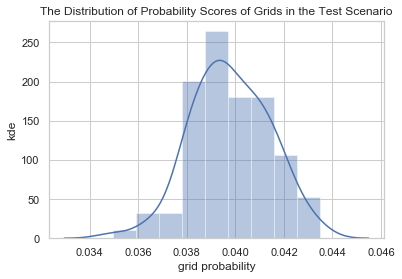

In [354]:
sns.distplot(test_results['all_scores'][1:])
plt.title(f"The Distribution of Probability Scores of Grids in the Test Scenario")
plt.ylabel('kde')
plt.xlabel('grid probability')
plt.show()

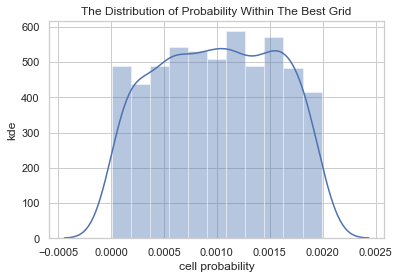

In [537]:
sns.distplot(test_results['best_grid'].flatten())
plt.title(f"The Distribution of Probability Within The Best Grid")
plt.ylabel('kde')
plt.xlabel('cell probability')
plt.show()

In [349]:
best_test_grid = test_results['best_grid']

In [352]:
best_test_cell = np.unravel_index(np.argmax(best_test_grid.flatten()), best_test_grid.shape)
best_test_cell

(8, 1, 6)

In [353]:
best_test_grid[best_test_cell]

0.001989853426282048

In [380]:
test_best_vote_pcts = get_vote_pcts(best_test_cell, best_test_grid.shape[0], test_demo)
test_best_vote_pcts

{'Black': 0.85, 'white': 0.15, 'Latinx': 0.65}

In [489]:
def test_prob_in_cell(index, grid):
    return grid[index]

### Visualizations

In [552]:
def visualize_3d_grid(grid, demo):
    grid_indices = np.arange(grid.shape[0])
    test_x, test_y = np.meshgrid(grid_indices, grid_indices)
    test_z, _ = np.meshgrid(grid_indices, grid_indices)
    
    # Set 4th dimension
    color_dimension = test_prob_in_cell((test_x, test_y, test_z), grid)
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = matplotlib.colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    ax.scatter(test_x, test_y, test_z, c=color_dimension.flatten(), cmap=plt.hot(), marker="^")
    colorbar = fig.colorbar(surface, shrink=0.5, aspect=10)
    colorbar.ax.set_ylabel('probability')
    plt.title("Distribution of Probability over the 3D Grid\n")
    
    demo_groups = list(demo.keys())
    ax.set_xlabel(f"{demo_groups[0]} voting index")
    ax.set_ylabel(f"{demo_groups[1]} voting index")
    ax.set_zlabel(f"{demo_groups[2]} voting index")
    ax.view_init(30, 30)
    plt.draw()

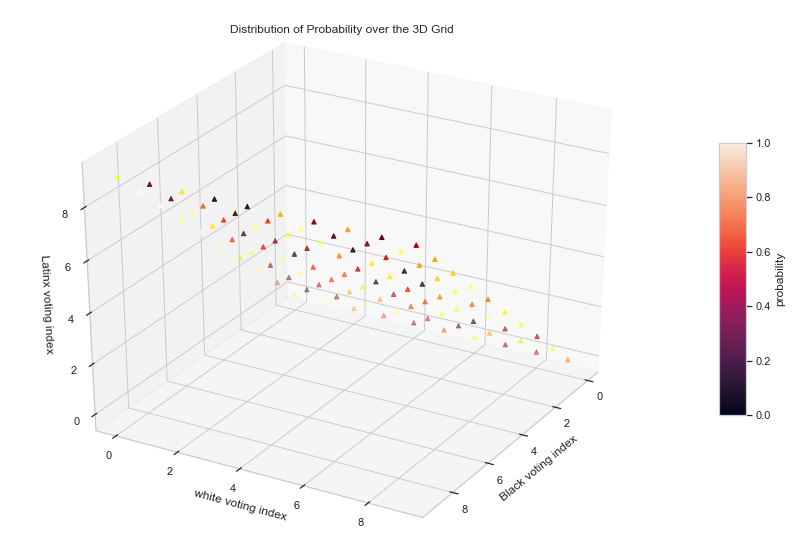

In [551]:
visualize_3d_grid(best_test_grid, test_demo)

In [394]:
test_grid_2d = make_grid(2, 10)
test_grid_2d

In [399]:
test_demo_2d = {'Black': 10, 'white': 8}

In [401]:
test_observed_2d = 7

In [408]:
test_results_2d = metropolis_hastings(100, test_grid_2d, test_observed_2d, test_demo_2d, scoring_type='prob', shift_type='uniform')

100%|██████████| 100/100 [00:01<00:00, 89.05it/s]


In [409]:
best_test_grid_2d = test_results_2d['best_grid']
best_test_grid_2d

array([[0.00176962, 0.00910411, 0.02132534, 0.00214673, 0.00491531,
        0.012186  , 0.02073707, 0.01119636, 0.02095889, 0.01324058],
       [0.00329417, 0.00058042, 0.01362255, 0.0023578 , 0.00147291,
        0.01269156, 0.0091377 , 0.02006492, 0.01791254, 0.01429386],
       [0.01912061, 0.01026564, 0.01557404, 0.00569451, 0.01558552,
        0.00726434, 0.01770231, 0.00057354, 0.0153244 , 0.02082664],
       [0.00577659, 0.01137331, 0.00640838, 0.01504918, 0.00538441,
        0.01158851, 0.00484246, 0.01298194, 0.02144744, 0.00151948],
       [0.00102396, 0.00484175, 0.00921055, 0.00703574, 0.00475795,
        0.01857046, 0.01877479, 0.00300041, 0.00803302, 0.00315371],
       [0.00240585, 0.00794914, 0.00662417, 0.01982493, 0.01927581,
        0.01151715, 0.01072349, 0.01175905, 0.00062662, 0.00477404],
       [0.00293423, 0.00330468, 0.01765157, 0.00203679, 0.00927572,
        0.00705075, 0.00108351, 0.01032535, 0.00831389, 0.00669071],
       [0.01452446, 0.02005106, 0.0044732

In [410]:
best_test_cell_2d = np.unravel_index(np.argmax(best_test_grid_2d.flatten()), best_test_grid_2d.shape)
best_test_cell_2d

(8, 8)

In [553]:
def visualize_2d_grid(grid, demo):
    grid_indices = np.arange(grid.shape[0])
    test_x, test_y = np.meshgrid(grid_indices, grid_indices)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    surface = ax.plot_surface(test_x, test_y, test_prob_in_cell((test_x, test_y), grid), rstride=1, cstride=1, edgecolor='none', cmap='viridis')
    colorbar = fig.colorbar(surface, shrink=0.5, aspect=10)
    colorbar.ax.set_ylabel('probability')
    plt.title("Distribution of Probability over the 2D Grid\n")
    
    demo_groups = list(demo.keys())
    ax.set_xlabel(f"{demo_groups[0]} voting index")
    ax.set_ylabel(f"{demo_groups[1]} voting index")
    plt.show()

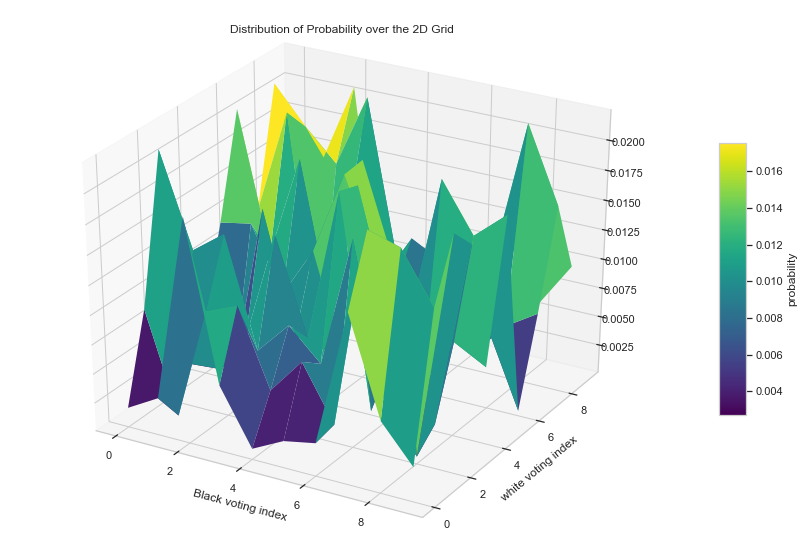

In [554]:
visualize_2d_grid(best_test_grid_2d, test_demo_2d)

### `generate_random_election`

Generate a random election.

In [525]:
def generate_random_election(candidates, demo, beta):
    """
    Generate a random election.
    
    candidates (string list): the candidates
    demo (dict): the demographics of the electorate
    beta (dict): the theoretical voting percentages of
    each demographic group, for each candidate
    
    return: a dictionary of candidates and the vote breakdowns by
    demographic group
    """
    # Set up the result dictionary
    num_groups = len(demo)
    result = {'a': (0, [0] * num_groups), 
              'b': (0, [0] * num_groups), 
              'c': (0, [0] * num_groups)}
    
    # Iterate through each demographic group
    for group_index, group in enumerate(demo):
        # Simulate each voter
        for voter in range(demo[group]):
            vote = np.random.choice(candidates, 1, beta[group])[0]
            prev_total, prev_breakdown = result[vote]
            prev_breakdown[group_index] += 1
            result[vote] = prev_total + 1, prev_breakdown
    return result

In [526]:
test_candidates = ['a', 'b', 'c']
test_beta = {'Black': [0.4, 0.5, 0.1], 
             'white': [0.3, 0.2, 0.5], 
             'Latinx': [0.3, 0.5, 0.2]}

In [527]:
test_random_election = generate_random_election(test_candidates, test_demo, test_beta)

In [528]:
test_random_election

{'a': (11, [6, 4, 1]), 'b': (7, [0, 4, 3]), 'c': (5, [4, 0, 1])}

In [529]:
test_observed_from_elec = 0
for candidate in test_random_election:
    test_observed_from_elec += test_random_election[candidate][0]
test_observed_from_elec

23

In [530]:
test_results_with_elec = metropolis_hastings(100, test_grid, test_observed_from_elec, test_demo, scoring_type='prob')

100%|██████████| 100/100 [08:42<00:00,  5.16s/it]


In [531]:
test_results_with_elec.keys()

dict_keys(['rejection_rate', 'best_grid', 'best_score', 'all_grids', 'all_scores'])

In [532]:
test_results_with_elec['best_grid']

array([[[8.35429366e-04, 1.80068542e-03, 8.07699829e-04, 3.25473789e-04,
         1.70311068e-03, 1.00114870e-03, 1.79867189e-03, 7.50936211e-05,
         1.47326089e-03, 1.38711487e-03],
        [5.53371449e-04, 2.04117987e-04, 1.82325600e-03, 1.81007285e-03,
         1.57899222e-03, 1.23041394e-03, 5.48614957e-04, 1.20470516e-03,
         1.76421365e-03, 1.04980360e-03],
        [1.72027466e-03, 2.01669089e-03, 4.14872124e-04, 1.02162323e-03,
         6.98183444e-04, 1.78205178e-03, 1.25681894e-03, 1.67022703e-03,
         1.53566257e-03, 9.84372760e-04],
        [1.58024157e-03, 2.56007923e-04, 1.33167321e-04, 7.89576944e-04,
         2.34677173e-04, 1.04680398e-03, 1.27311252e-03, 1.39927650e-03,
         1.56603518e-04, 1.03535576e-03],
        [9.50244008e-04, 1.00816005e-03, 1.85943770e-03, 7.27465937e-04,
         3.56299838e-04, 5.32154605e-04, 6.53057361e-04, 1.63736368e-03,
         3.29457542e-04, 2.02157357e-03],
        [7.83341828e-04, 1.78353613e-03, 1.76817996e-03, 1.9

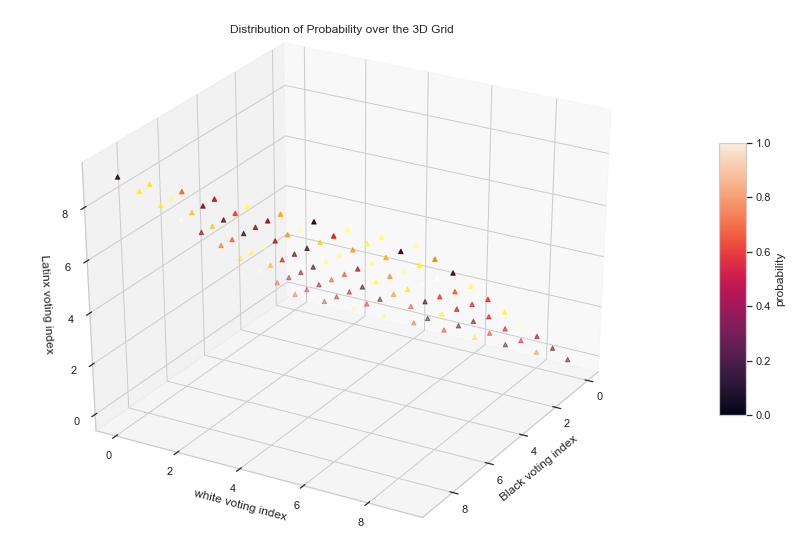

In [555]:
visualize_3d_grid(test_results_with_elec['best_grid'], test_demo)